In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import openai


In [2]:
openai.__version__

'0.28.0'

In [3]:
#Open AI set up

#4,oMWXRSsSu58dYT6KbF4R,50000000,Public Opinion
openai.api_base="http://91.107.239.71:80"
api_key = "oMWXRSsSu58dYT6KbF4R"
openai.api_key = api_key

In [4]:
anes = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')

C:\Users\agust\AppData\Local\Temp\ipykernel_13916\245263837.py:1: DtypeWarning: Columns (15,17,18,19,21,22,23,25,26,27,29,30,31,33,34,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  anes = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')


In [5]:
questcode_topic = {"V201336": "abortion1",
              "V201342x": "abortion2",
              "V202332": "climate change1",
              "V202333": "climate change2",
              "V202337": "gun control1",
              "V202341x": "gun control2",
              "V202344x": "gun control3",
              "V202232": "immigration1",
              "V202233": "immigration2",
              "V202236x":"immigration3",
              "V202380x": "public health1"}

In [6]:
# Questions
questions = {
# Abortion 1:
"V201336":
"""There has been some discussion about abortion during recent
years. Which one of the opinions on this page best agrees with
your view?
1. By law, abortion should never be permitted
2. The law should permit abortion only in case of rape, incest, or
when the woman’s life is in danger
3. The law should permit abortion other than for
rape/incest/danger to woman but only after need clearly
established
4. By law, a woman should always be able to obtain an abortion
as a matter of personal choice"""
# Put "You can just tell me the number of the opinion you choose." away not to mix the LLMs


# Abortion 2:
, "V201342x":
"""Would you be pleased, upset, or neither pleased nor upset if the
Supreme Court reduced abortion rights?
1. Extremely pleased
2. Moderately pleased
3. A little pleased
4. Neither pleased nor upset
5. A little upset
6. Moderately upset
7. Extremely upset"""


# Climate change 1:
, "V202332":
"""How much, if at all, do you think climate change is currently
affecting severe weather events or temperature patterns in the
United States?
1. Not at all
2. A little
3. A moderate amount
4. A lot
5. A great deal"""

# Climate change 2:
, "V202333":
"""How important is the issue of climate change to you personally?
1. Not at all important
2. A little important
3. Moderately important
4. Very important
5. Extremely important"""


# Gun control 1:
, "V202337":
"""Do you think the federal government should make it more
difficult for people to buy a gun than it is now, make it easier for
people to buy a gun, or keep these rules about the same as they
are now?
1. More difficult
2. Easier
3. Keep these rules about the same"""

# Gun control 2:
, "V202341x":
"""Do you favor, oppose, or neither favor nor oppose requiring
background checks for gun purchases at gun shows or other
private sales?
1. Favor a great deal
2. Favor a moderate amount
3. Favor a little
4. Neither favor nor oppose
5. Oppose a little
6. Oppose a moderate amount
7. Oppose a great deal"""

# Gun control 3:
, "V202344x":
"""Do you favor, oppose, or neither favor nor oppose banning the
sale of semi-automatic “assault-style” rifles?
1. Favor a great deal
2. Favor a moderate amount
3. Favor a little
4. Neither favor nor oppose
5. Oppose a little
6. Oppose a moderate amount
7. Oppose a great deal"""

# Immigration 1:
, "V202232":
"""Do you think the number of immigrants from foreign countries
who are permitted to come to the United States to live should be
increased a lot, increased a little, left the same as it is now,
decreased a little, or decreased a lot?
1. Increased a lot
2. Increased a little
3. Left the same as it is now
4. Decreased a little
5. Decreased a lot"""

# Immigration 2:
, "V202233":
"""Now I’d like to ask you about immigration in recent years.
How likely is it that recent immigration levels will take jobs away
from people already here – extremely likely, very likely,
somewhat likely, or not at all likely?
1. Extremely likely
2. Very likely
3. Somewhat likely
4. Not at all likely"""

# Immigration 3:
, "V202236x":
"""Do you favor, oppose, or neither favor nor oppose allowing
refugees who are fleeing war, persecution, or natural disasters
in other countries to come to live in the U.S.?
1. Favor a great deal
2. Favor a moderate amount
3. Favor a little
4. Neither favor nor oppose
5. Oppose a little
6. Oppose a moderate amount
7. Oppose a great deal"""

# Public Health 1:
, "V202380x":
"""Do you favor an increase, decrease, or no change in
government spending tohelp people pay for health insurance
when they can’t pay for it all themselves?
1. Increase a great deal
2. Increase a moderate amount
3. Increase a little
4. No change
5. Decrease a little
6. Decrease a moderate amount
7. Decrease a great deal"""
}

In [7]:
mean_var = {}

for key, value in questions.items():
    # Only include valid answers
    valid = anes[anes[key] > 0]
    # frequencies = valid[key].value_counts()
    column_mean = valid[key].mean()
    column_var = valid[key].var()
    num_respondents = len(valid[key])
    mean_var[key] = [column_mean, column_var, num_respondents]
mean_var

{'V201336': [3.119030214424951, 1.282893564092481, 8208],
 'V201342x': [4.689327485380117, 4.338709039566053, 8208],
 'V202332': [3.5717382468500203, 1.8473258263269425, 7381],
 'V202333': [3.340511986997156, 1.825786082997807, 7383],
 'V202337': [1.89735593220339, 0.9236911365172453, 7375],
 'V202341x': [1.6703668607012319, 1.812394165422136, 7387],
 'V202344x': [3.207424468229237, 5.664150831861712, 7381],
 'V202232': [2.9915646258503403, 1.2937103016468015, 7350],
 'V202233': [3.0364054675869534, 0.8464005047669663, 7389],
 'V202236x': [3.072867378667027, 3.1129968202944625, 7397],
 'V202380x': [3.0557224801966676, 2.7443334555495578, 7322]}

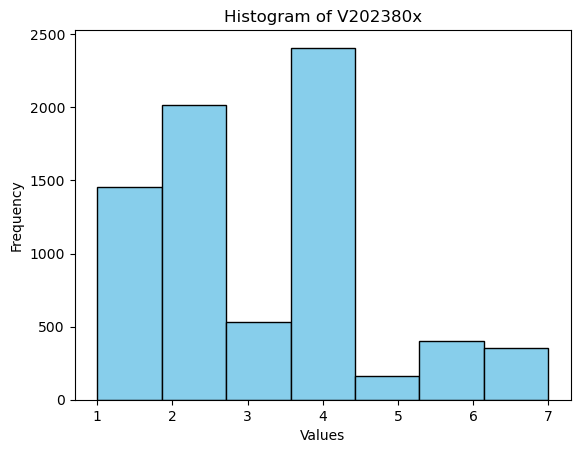

In [8]:
# Build histogram per answer?
jaha = anes[anes["V202380x"] > 0]

num_answers = len(jaha["V202380x"].unique())
plt.hist(jaha["V202380x"], color='skyblue', edgecolor='black', bins=num_answers)
plt.title('Histogram of V202380x')
plt.xlabel('Values')
plt.ylabel('Frequency')
# plt.grid(True)
plt.show()

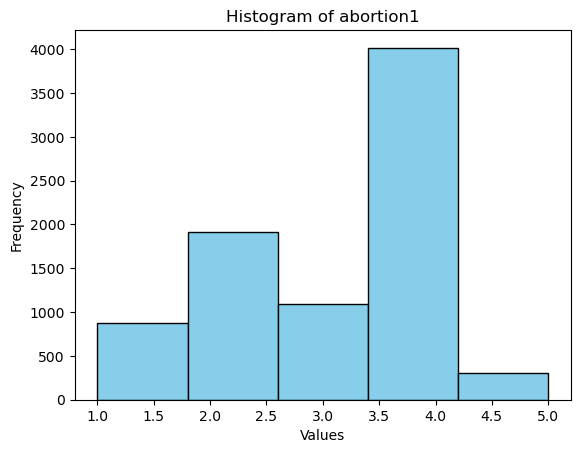

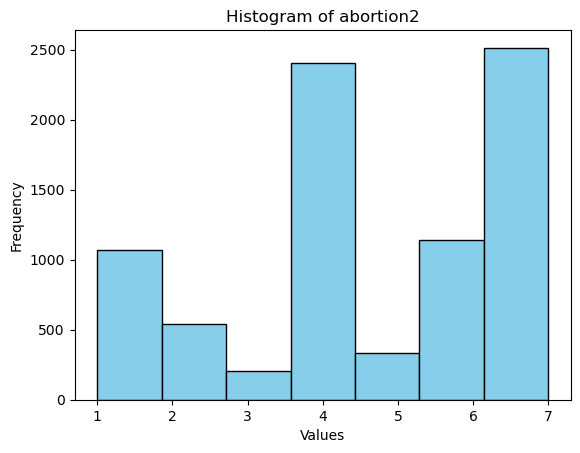

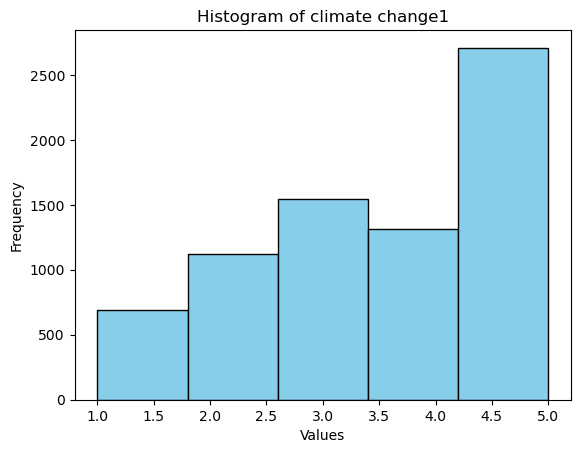

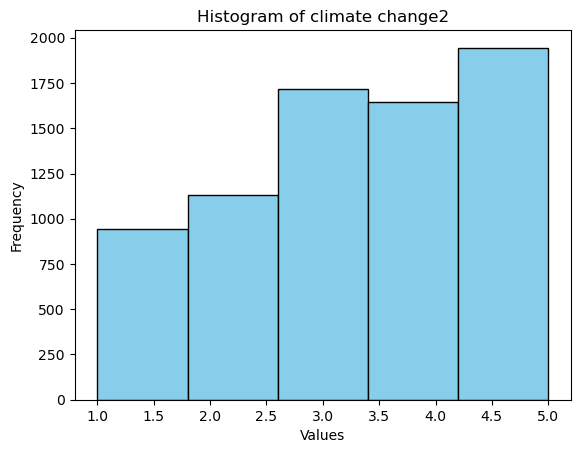

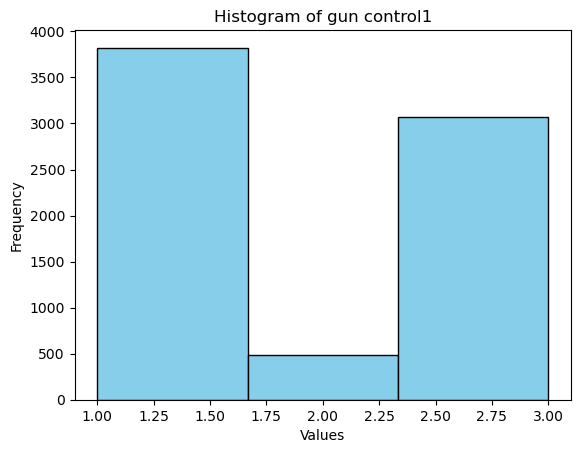

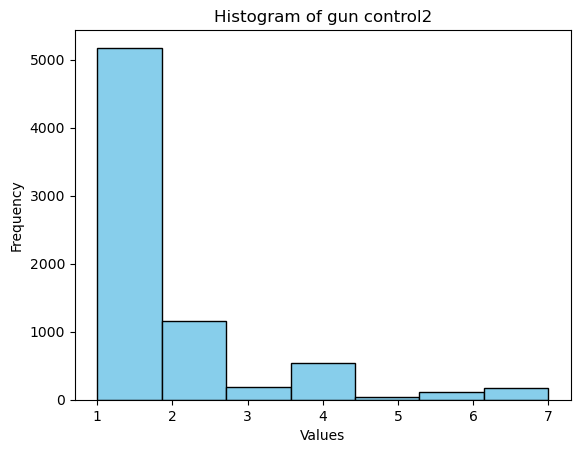

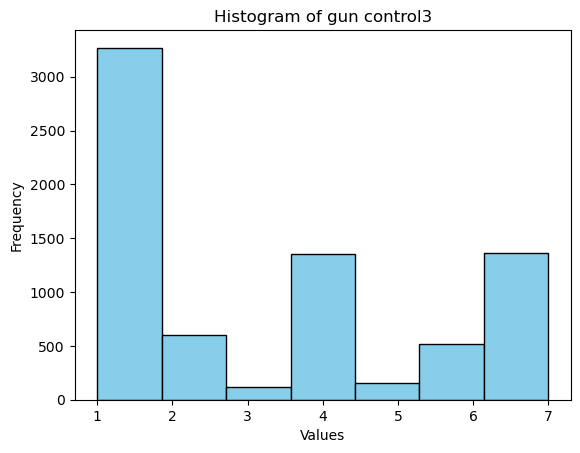

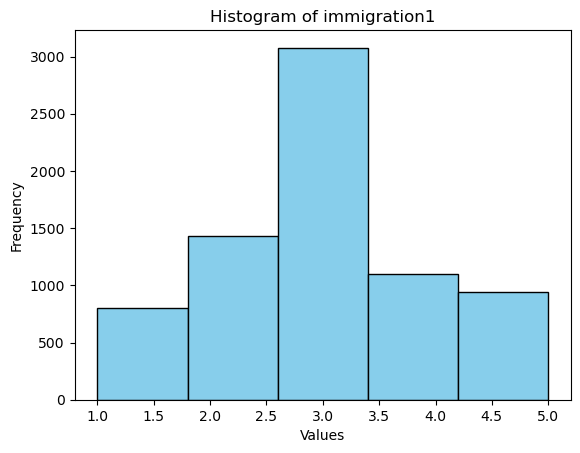

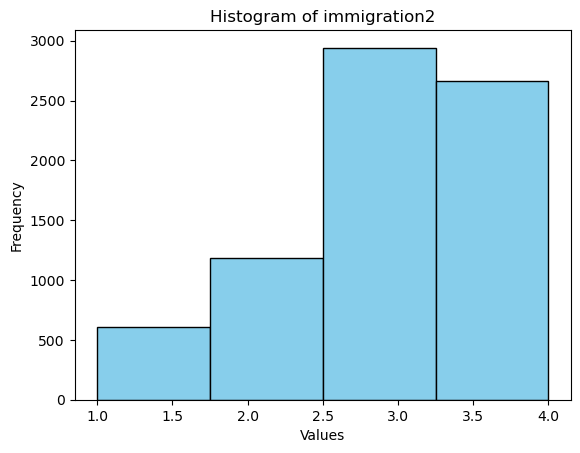

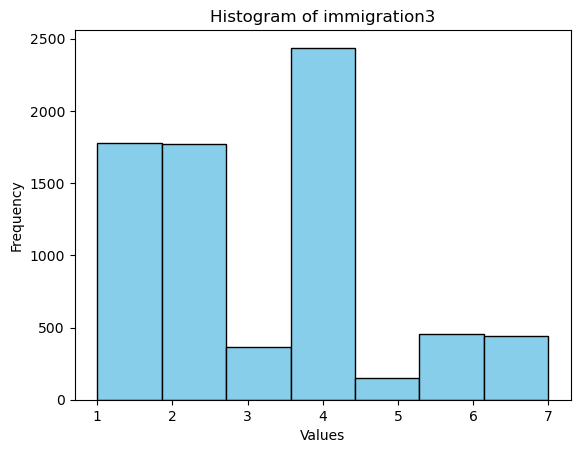

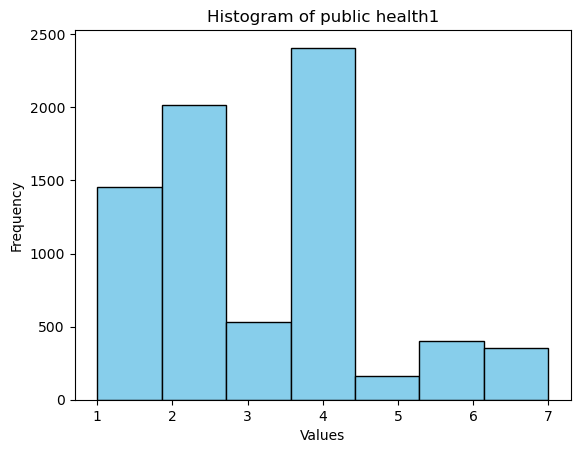

In [9]:
for key, values in mean_var.items():
    issue = questcode_topic[key]
    valid_ans = anes[anes[key] > 0]
    
    # Calculate number of unique answers
    num_answers = len(valid_ans[key].unique())
    
    # Create histogram
    plt.hist(valid_ans[key], color='skyblue', edgecolor='black', bins=num_answers)
    plt.title('Histogram of {}'.format(issue))
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    # plt.grid(True)
    plt.show()

In [10]:
# Prompt
# def prompt(question, num_respondents):
#     prompt_text = 'In the following you will be given a question with several answer possibilities. Please try to \
#     estimate how a representative sample of %d US-Americans would have answered the question in 2020 and provide a \
#     frequency table: %s' % (num_respondents, question)

#     return prompt_text

In [11]:
# Prompt2
def prompt(question, num_respondents):
    prompt_text = 'In the following you will be given a question followed several possible answer categories. Please \
    estimate how a representative sample of %d US-Americans would have answered the question in 2020 by providing a \
    frequency table that shows answer frequency of each answer option (output a dictionary object with answer category \
    number as key and answer frequency as value): %s'%(num_respondents, question)
    
    return prompt_text

In [20]:
#Test with one question
question = "V201336"

#original survey valid answers
valid_ans = anes[anes[question] > 0]
survey_ans = len(valid_ans)

#prompt for question (question + total answers)
prompt_text = prompt(questions[question], survey_ans)

#answer generation
responses = openai.ChatCompletion.create(model="gpt-3.5-turbo-0125", 
                                         messages=[{"role": "user", "content": prompt_text}]#,
                                         #n = 5
                                         )

final_ans = [i['message']['content'] for i in responses['choices']]
final_ans_dict = [eval(i) for i in final_ans]
#also include in the final object the info on the total number of respondents
final_ans_dict.append(survey_ans)
final_ans_dict

[{1: 1152, 2: 1863, 3: 2086, 4: 3107}]

In [16]:
#check if the answers are correct
print(survey_ans)
print(1320 +1801 +2397 +2690)

8208
8208


In [24]:
#2 questions to test function and not loose tokens
q2 = {key: questions[key] for key in ['V201336', 'V202333']}
q2

{'V201336': 'There has been some discussion about abortion during recent\nyears. Which one of the opinions on this page best agrees with\nyour view?\n1. By law, abortion should never be permitted\n2. The law should permit abortion only in case of rape, incest, or\nwhen the woman’s life is in danger\n3. The law should permit abortion other than for\nrape/incest/danger to woman but only after need clearly\nestablished\n4. By law, a woman should always be able to obtain an abortion\nas a matter of personal choice',
 'V202333': 'How important is the issue of climate change to you personally?\n1. Not at all important\n2. A little important\n3. Moderately important\n4. Very important\n5. Extremely important'}

In [38]:
openai_ans = {}
for question in q2: #"questions" object has all questions 
    
    #original survey valid answers
    valid_ans = anes[anes[question] > 0]
    survey_ans = len(valid_ans)

    #prompt for question (question + total answers)
    prompt_text = prompt(questions[question], survey_ans)

    #answer generation
    responses = openai.ChatCompletion.create(model="gpt-3.5-turbo-0125", 
                                            messages=[{"role": "user", "content": prompt_text}]#,
                                            #n = 5
                                            )

    final_ans = [i['message']['content'] for i in responses['choices']]
    final_ans_dict = [eval(i) for i in final_ans]
    #also include in the final object the info on the total number of respondents
    final_ans_dict.append(survey_ans)
    openai_ans[question] = final_ans_dict

In [37]:
openai_ans

{'V201336': [{1: 1120, 2: 2089, 3: 3156, 4: 1843}, 8208],
 'V202333': [{1: 1123, 2: 1876, 3: 2367, 4: 1792, 5: 1225}, 7383]}